# code to try training with apple silicon

## libraries

In [1]:
from ase.io import read, write
import random
import os 

In [7]:
data = read('../data/zr-w-v-cr-ti/old/fep_train.xyz', index=':')
data_test = read('../data/zr-w-v-cr-ti/old/fep_test.xyz', index=':')

print(len(data))
print(len(data_test))

print(data[0].info)
print(data[0].arrays.keys())

# combine
data.extend(data_test)

# change the 

# split into train, val, test, 80/10/10
n = len(data)
n_train = int(n * 0.8)
n_val = int(n * 0.1)
n_test = n - n_train - n_val

# shuffle the data
random.seed(42)
random.shuffle(data)

# split the data 
data_train = data[:n_train]
data_val = data[n_train:n_train+n_val]
data_test = data[n_train+n_val:]

print(len(data_train))
print(len(data_val))
print(len(data_test))

# write the data
write('../data/zr-w-v-cr-ti/mace_fep_train.xyz', data_train)
write('../data/zr-w-v-cr-ti/mace_fep_val.xyz', data_val)
write('../data/zr-w-v-cr-ti/mace_fep_test.xyz', data_test)

461
52
{'REF_energy': -1101.51738703, 'REF_stress': array([-2.64789783e-04,  4.02202848e-05,  4.10316810e-05,  4.02202848e-05,
       -4.74167448e-04, -1.94073485e-04,  4.10316810e-05, -1.94073485e-04,
       -6.73708495e-04])}
dict_keys(['numbers', 'positions', 'REF_force'])
410
51
52


In [18]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 5.0
E0s: "average"
name: "mace02_com1"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "../data/zr-w-v-cr-ti/mace_fep_train.xyz"
valid_file: "../data/zr-w-v-cr-ti/mace_fep_val.xyz"
test_file: "../data/zr-w-v-cr-ti/mace_fep_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_force"
stress_key: "REF_stress"
loss: "stress"
energy_weight: 1.0
forces_weight: 50.0
stress_weight: 25.0
lr: 0.001
default_dtype: "float32"
device: mps
batch_size: 5
max_num_epochs: 200
swa: True
seed: 123

Overwriting config/config-01.yml


In [3]:
# run the config 
import warnings 
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging 
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

In [4]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
train_mace("config/config-01.yml")

env: PYTORCH_ENABLE_MPS_FALLBACK=1
2024-10-24 12:01:28.374 INFO: ===========VERIFYING SETTINGS===========
2024-10-24 12:01:28.374 INFO: MACE version: 0.3.7
2024-10-24 12:01:28.397 INFO: Using MPS GPU acceleration
2024-10-24 12:01:28.500 INFO: ===========LOADING INPUT DATA===========
2024-10-24 12:01:28.501 INFO: Using heads: ['default']
2024-10-24 12:01:28.501 INFO: =============    Processing head default     ===========
2024-10-24 12:01:28.663 INFO: Training set [410 configs, 410 energy, 153750 forces] loaded from '../data/zr-w-v-cr-ti/mace_fep_train.xyz'
2024-10-24 12:01:28.691 INFO: Validation set [51 configs, 51 energy, 19125 forces] loaded from '../data/zr-w-v-cr-ti/mace_fep_val.xyz'
2024-10-24 12:01:28.720 INFO: Test set (52 configs) loaded from '../data/zr-w-v-cr-ti/mace_fep_test.xyz':
2024-10-24 12:01:28.721 INFO: Default_Default: 52 configs, 52 energy, 19500 forces
2024-10-24 12:01:28.722 INFO: Total number of configurations: train=410, valid=51, tests=[Default_Default: 52],


KeyboardInterrupt: 

# code to use ensemble md 

This notebook looks to use ensemble md, similar to mace's tutorial to generate training data 

## libraries

In [17]:
from ase.io import read, write
import numpy as np
from ase import Atoms
import json
import random
from typing import List, Dict
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
#from aseMolec import extAtoms as ea
import matplotlib
import os
import time
import numpy as np
import pylab as pl
from IPython import display
np.random.seed(701) #just making sure the MD failure is reproducible

def load_historical_compositions(json_file: str) -> Dict[int, List[Dict[str, float]]]:
    """Load compositions from generations 0-3 from JSON file"""
    with open(json_file, 'r') as f:
        all_comps = json.load(f)
    # Filter for generations 0-3
    gen_comps = {}
    for comp in all_comps:
        gen = comp['Generation']
        if gen <= 3:
            if gen not in gen_comps:
                gen_comps[gen] = []
            gen_comps[gen].append(comp)
    return gen_comps

def generate_nary_composition(n_elements: int, elements: List[str] = ['V', 'Cr', 'Ti', 'Zr', 'W']) -> Dict[str, float]:
    """Generate n-ary composition with V-rich preference"""
    # Sample V content from normal distribution
    v_content = np.random.normal(0.75, 0.125)
    v_content = np.clip(v_content, 0.0, 1.0)
    
    # Select n-1 other elements randomly (V is always included)
    other_elements = random.sample([e for e in elements if e != 'V'], n_elements - 1)
    
    # Distribute remaining fraction among other elements
    remaining = 1.0 - v_content
    other_fractions = np.random.dirichlet(np.ones(n_elements - 1)) * remaining
    
    # Create composition dictionary
    composition = {'V': v_content}
    for elem, frac in zip(other_elements, other_fractions):
        composition[elem] = frac
    
    # Fill remaining elements with 0
    for elem in elements:
        if elem not in composition:
            composition[elem] = 0.0
            
    return composition

def generate_equimolar_composition(elements: List[str] = ['V', 'Cr', 'Ti', 'Zr', 'W']) -> Dict[str, float]:
    """Generate equimolar composition"""
    fraction = 1.0 / len(elements)
    return {elem: fraction for elem in elements}

def generate_target_composition(historical_comps: Dict[int, List[Dict[str, float]]]) -> Dict[str, float]:
    """Generate a target composition based on the defined probabilities"""
    rand = random.random()
    
    if rand < 0.70:  # Historical composition
        # Randomly select generation and composition
        gen = random.choice(list(historical_comps.keys()))
        comp = random.choice(historical_comps[gen])
        return {k: v for k, v in comp.items() if k != 'Generation'}
    
    elif rand < 0.95:  # N-ary composition
        n_elements = random.randint(1, 4)  # Unary to quaternary
        return generate_nary_composition(n_elements)
    
    else:  # Equimolar
        return generate_equimolar_composition()

def _modify_atoms_composition(atoms: Atoms, target_comp: Dict[str, float]) -> Atoms:
    """Modify atoms object to match target composition as closely as possible"""
    # Create a copy of the atoms object
    new_atoms = atoms.copy()
    
    # Count total number of atoms (excluding vacancies if present)
    total_atoms = len([sym for sym in new_atoms.symbols if sym in target_comp])
    
    # Calculate target number of atoms for each element
    target_counts = {elem: int(round(frac * total_atoms)) 
                    for elem, frac in target_comp.items()}
    
    # Adjust one random element to make sure total adds up
    total_target = sum(target_counts.values())
    if total_target != total_atoms:
        diff = total_atoms - total_target
        elem = random.choice(list(target_counts.keys()))
        target_counts[elem] += diff
    
    # Create list of new symbols
    current_positions = []
    current_symbols = []
    for i, (pos, sym) in enumerate(zip(new_atoms.positions, new_atoms.symbols)):
        if sym in target_comp:
            current_positions.append(pos)
            current_symbols.append(sym)
    
    # Create new symbol list based on target composition
    new_symbols = []
    remaining_elements = list(target_counts.items())
    while remaining_elements:
        elem, count = remaining_elements[0]
        if count > 0:
            new_symbols.append(elem)
            target_counts[elem] -= 1
            if target_counts[elem] == 0:
                remaining_elements.pop(0)
        else:
            remaining_elements.pop(0)
    
    # Randomly shuffle new symbols
    random.shuffle(new_symbols)
    
    # Create new atoms object with modified composition
    new_atoms = Atoms(symbols=new_symbols, positions=current_positions)
    
    return new_atoms

def modify_atoms_composition(atoms: Atoms, target_comp: Dict[str, float]) -> Atoms:
    """Modify atoms object to match target composition as closely as possible"""
    # Get initial composition
    symbols = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    
    # Count total atoms
    n_atoms = len(atoms)
    print(f"Initial composition: {dict(zip(*np.unique(symbols, return_counts=True)))}")
    print(f"Target composition: {target_comp}")
    
    # Calculate target counts
    target_counts = {elem: int(round(frac * n_atoms)) 
                    for elem, frac in target_comp.items()}
    
    # Ensure total matches original atom count
    total_target = sum(target_counts.values())
    if total_target != n_atoms:
        # Find element with highest count to adjust
        max_elem = max(target_counts.items(), key=lambda x: x[1])[0]
        adjustment = n_atoms - total_target
        target_counts[max_elem] += adjustment
        print(f"Adjusted {max_elem} count by {adjustment}")
        print(f"New target counts: {target_counts}")
    
    # Create new symbol list
    new_symbols = []
    for elem, count in target_counts.items():
        new_symbols.extend([elem] * count)
    
    # Randomly shuffle the new symbols
    np.random.shuffle(new_symbols)
    
    print(f"Length of new_symbols: {len(new_symbols)}")
    print(f"Length of filtered_positions: {len(positions)}")
    print(f"New composition: {dict(zip(*np.unique(new_symbols, return_counts=True)))}")
    
    # Create new atoms object with modified composition
    new_atoms = Atoms(symbols=new_symbols,
                     positions=positions,
                     cell=atoms.cell,
                     pbc=atoms.pbc)
    
    return new_atoms

def process_structures(atoms_list: List[Atoms], historical_comps: Dict[int, List[Dict[str, float]]]) -> List[Atoms]:
    """Process list of atoms objects and create modified versions"""
    new_structures = []
    
    for atoms in atoms_list:
        # Generate target composition
        target_comp = generate_target_composition(historical_comps)
        
        # Modify atoms to match target composition
        new_atoms = modify_atoms_composition(atoms, target_comp)
        
        # Add to list of new structures
        new_structures.append(new_atoms)
    
    return new_structures

def simpleMD(init_conf, temp, calc, fname, s, T):
    """
    Perform a simple molecular dynamics (MD) simulation using Langevin dynamics.

    Parameters:
    init_conf : Atoms object
        Initial atomic configuration.
    temp : float
        Desired temperature for the simulation in Kelvin.
    calc : Calculator object
        Calculator to be used for energy and force calculations.
    fname : str
        Filename to store the trajectory.
    s : int
        Interval for writing frames to the trajectory file.
    T : int
        Total number of steps for the MD simulation.

    Returns:
    None
    """
    
    # Set the calculator
    init_conf.calc = calc

    #initialize the temperature

    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.5) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace'] = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['force_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True, write_results=False)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## generate initial configs

In [18]:
# use the code to read in various training data in superset, select at random for now, in future, select the most uncertain
comps = load_historical_compositions('../data/zr-w-v-ti-cr/compositions_gen4.json')

data = read('../data/zr-w-v-ti-cr/gen_0_2024-11-06/2024-11-06_all_remaining_atoms.xyz', index=':')

# load the sorted var data
sorted_var_data = json.load(open('../data/zr-w-v-ti-cr/gen_0_2024-11-06/all_structures_var_data.json', 'r'))

# get the top 100 structures except for the first one which was invalid 
top_structures = sorted_var_data[1:101]

starting_atoms = [data[i[0]] for i in top_structures]


# set the random seed
random.seed(42)

In [19]:
#print(len(top_structures))
#print(top_structures[0])
#print(sorted_var_data[0])

generated_atoms_list = process_structures(starting_atoms, comps)

# save the generated atoms list to an xyz file 
write('../data/zr-w-v-ti-cr/gen_0_2024-11-06/gen_1_2024-11-07_initial_configs.xyz', generated_atoms_list)

Initial composition: {'Cr': 14, 'Ti': 18, 'V': 74, 'W': 7, 'Zr': 11}
Target composition: {'Cr': 0.0923, 'Ti': 0.0513, 'Zr': 0.0206, 'W': 0.0322, 'V': 0.8036}
Length of new_symbols: 124
Length of filtered_positions: 124
New composition: {'Cr': 11, 'Ti': 6, 'V': 100, 'W': 4, 'Zr': 3}
Initial composition: {'Cr': 10, 'Ti': 14, 'V': 87, 'W': 2, 'Zr': 11}
Target composition: {'Cr': 0.05070870360836058, 'Ti': 0.07347325080117553, 'Zr': 0.0658011067006642, 'W': 0.007999866013981916, 'V': 0.8020170728758178}
Adjusted V count by 1
New target counts: {'Cr': 6, 'Ti': 9, 'Zr': 8, 'W': 1, 'V': 100}
Length of new_symbols: 124
Length of filtered_positions: 124
New composition: {'Cr': 6, 'Ti': 9, 'V': 100, 'W': 1, 'Zr': 8}
Initial composition: {'Cr': 14, 'Ti': 18, 'V': 74, 'W': 7, 'Zr': 11}
Target composition: {'V': 0.9810031946416867, 'Cr': 0.0, 'Ti': 0.0, 'Zr': 0.0, 'W': 0.0}
Adjusted V count by 2
New target counts: {'V': 124, 'Cr': 0, 'Ti': 0, 'Zr': 0, 'W': 0}
Length of new_symbols: 124
Length of fi

In [20]:
for i, atoms in enumerate(generated_atoms_list):
    print(f"Composition {i+1}: {atoms.get_chemical_formula()}")

Composition 1: Cr11Ti6V100W4Zr3
Composition 2: Cr6Ti9V100WZr8
Composition 3: V124
Composition 4: Cr8Ti2V107W4Zr3
Composition 5: CrTi2V101W4Zr16
Composition 6: CrTi2V101W4Zr16
Composition 7: Ti3V109W5Zr7
Composition 8: Cr2Ti3V108W7Zr4
Composition 9: Cr7Ti5V108W2Zr2
Composition 10: Cr8Ti13V102W
Composition 11: Cr9Ti2V107W4Zr2
Composition 12: Cr17V71Zr36
Composition 13: Cr2Ti4V112W4Zr2
Composition 14: CrTi2V101W19Zr
Composition 15: Ti3V114Zr7
Composition 16: Cr6Ti9V100W6Zr3
Composition 17: Cr25Ti25V24W25Zr25
Composition 18: V124
Composition 19: Cr5TiV107WZr10
Composition 20: Cr7Ti2V105W3Zr7
Composition 21: Cr11Ti10V99W2Zr2
Composition 22: Cr6Ti9V100WZr8
Composition 23: Cr7Ti5V107W2Zr3
Composition 24: Cr10Ti2V99W11Zr2
Composition 25: Cr9Ti2V107W4Zr2
Composition 26: Cr4Ti8V106WZr5
Composition 27: Ti24V82Zr18
Composition 28: Cr6Ti2V111W2Zr3
Composition 29: CrTi2V101W4Zr16
Composition 30: Ti3V109W5Zr7
Composition 31: Cr6Ti9V100WZr8
Composition 32: Cr8Ti2V107W4Zr3
Composition 33: Ti39V85
Compo

## run NN-MD on them

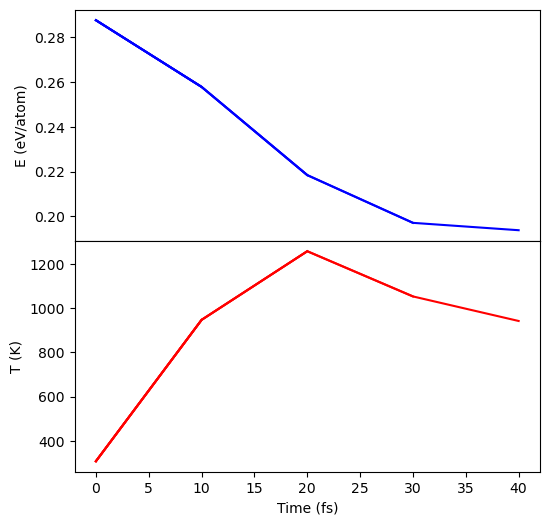

In [21]:
#let us start with a single structure at random from the generated atoms lists
#random_index = np.random.randint(0, len(generated_atoms_list))
#init_conf = generated_atoms_list[random_index]

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator

model_paths = ['../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_0-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_1-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_2-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_3-11-06-fixedtest_stagetwo_compiled.model',
               '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_4-11-06-fixedtest_stagetwo_compiled.model']

for t in [1000, 2000, 3000]:
    for i, atoms in enumerate(generated_atoms_list):
        mace_calc = MACECalculator(model_paths=model_paths, device='cuda', default_dtype='float32')
        comp = str(atoms.get_chemical_formula()).replace(' ', '')
        filename = f'../data/zr-w-v-ti-cr/gen_0_2024-11-06/md_frames/gen_0_idx-{i}_comp-{comp}_temp-{t}_md.xyz'
        if not os.path.exists(filename):
            simpleMD(atoms, temp=t, calc=mace_calc, fname=filename, s=10, T=1000)
        else:
            print(f"Skipping {filename} - file already exists")

In [13]:
finished_atoms = read('./vcrtiwzr_nnmd/gen_0_md.xyz', index=':')
print(f"Number of frames: {len(finished_atoms)}")

for i, atoms in enumerate(finished_atoms):
    print(f"Frame {i+1} : {atoms.get_potential_energy()} eV")   


Number of frames: 201


RuntimeError: Atoms object has no calculator.